In [1]:
import os
import pickle
import xarray as xr
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer, Proj
from scipy.spatial.distance import cdist
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import matplotlib.pyplot as plt

import geopandas as gpd


In [29]:
path_save = "/glade/p/cisl/aiml/jtti_tornado/gridrad_soundings/"
soundings = os.listdir(os.path.join(path_save, "final_rap_all"))
temps = [f'TMP_{p}_C' for p in range(100, 1025, 25)]
dews = [f'T_DEWPOINT_{p}_C' for p in range(100, 1025, 25)]
us = [f'UGRD_{p}_m/s' for p in range(100, 1025, 25)]
vs = [f'VGRD_{p}_m/s' for p in range(100, 1025, 25)]

columns = temps + dews + us + vs + ['HGT_ON_SFC_m']


In [ ]:
surface_vars_to_save = ['HGT_ON_SFC_m','PRES_ON_SURFACE_Pa', 'TEMPERATURE_2M_C', 'DEWPOINT_2M_C', 'VGRD_10M_m/s', 'UGRD_10M_m/s']

In [31]:
df = pd.read_parquet(os.path.join(path_save, "final_rap_all", soundings[0]))
# df = df.dropna(subset=columns, how='all').reset_index(drop=True)
print(list(df.columns))


['full_id_string', 'primary_id_string', 'secondary_id_string', 'first_prev_secondary_id_string', 'second_prev_secondary_id_string', 'first_next_secondary_id_string', 'second_next_secondary_id_string', 'valid_time_unix_sec', 'spc_date_string', 'tracking_start_time_unix_sec', 'tracking_end_time_unix_sec', 'cell_start_time_unix_sec', 'cell_end_time_unix_sec', 'age_seconds', 'centroid_latitude_deg', 'centroid_longitude_deg', 'east_velocity_m_s01', 'north_velocity_m_s01', 'run_time_unix_sec', 'datetime', 'datetime_rap', 'date_rap', 'hour_rap', 'idx', 'HGT_100_m', 'HGT_125_m', 'HGT_150_m', 'HGT_175_m', 'HGT_200_m', 'HGT_225_m', 'HGT_250_m', 'HGT_275_m', 'HGT_300_m', 'HGT_325_m', 'HGT_350_m', 'HGT_375_m', 'HGT_400_m', 'HGT_425_m', 'HGT_450_m', 'HGT_475_m', 'HGT_500_m', 'HGT_525_m', 'HGT_550_m', 'HGT_575_m', 'HGT_600_m', 'HGT_625_m', 'HGT_650_m', 'HGT_675_m', 'HGT_700_m', 'HGT_725_m', 'HGT_750_m', 'HGT_775_m', 'HGT_800_m', 'HGT_825_m', 'HGT_850_m', 'HGT_875_m', 'HGT_900_m', 'HGT_925_m', 'HGT_9

In [4]:
df

,full_id_string,primary_id_string,secondary_id_string,first_prev_secondary_id_string,second_prev_secondary_id_string,first_next_secondary_id_string,second_next_secondary_id_string,valid_time_unix_sec,spc_date_string,tracking_start_time_unix_sec,...,T_DEWPOINT_775_C,T_DEWPOINT_800_C,T_DEWPOINT_825_C,T_DEWPOINT_850_C,T_DEWPOINT_875_C,T_DEWPOINT_900_C,T_DEWPOINT_925_C,T_DEWPOINT_950_C,T_DEWPOINT_975_C,T_DEWPOINT_1000_C
0,140300640052_140300640068,140300640052,140300640068,,,140300640068,,1403031600,20140617,1403031600,...,7.523289,10.116043,12.163789,13.236966,13.972375,14.483039,16.100487,17.571445,18.959705,20.317314
1,140300640019_140300640001,140300640019,140300640001,,,140300640001,,1403031600,20140617,1403031600,...,9.140505,12.327488,14.044935,15.231946,15.843999,16.501118,17.892187,19.362680,20.750504,22.107679
2,140300640053_140300640002,140300640053,140300640002,,,140300640002,,1403031600,20140617,1403031600,...,8.526196,10.613023,12.841584,14.224410,15.207662,15.838914,17.044048,18.517397,19.907919,21.267752
3,140300640003_140300640003,140300640003,140300640003,,,140300640003,,1403031600,20140617,1403031600,...,9.223228,10.456975,12.569095,13.821626,14.475430,15.449235,16.865870,18.226681,19.624559,21.111832
4,140300640014_140300640014,140300640014,140300640014,,,140300640014,,1403031600,20140617,1403031600,...,8.691757,11.516650,13.384493,14.685507,15.479572,16.022419,17.187922,18.653231,20.036119,21.388458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,140300640101_140300640139,140300640101,140300640139,140300640139,,140300640139,,1403049300,20140617,1403031600,...,10.526318,12.429730,14.561104,15.380179,16.103321,17.443874,18.991394,20.423941,21.859289,23.099104
737,140300640108_140300640148,140300640108,140300640148,,,140300640148,,1403049300,20140617,1403031600,...,2.815240,3.018321,4.236870,5.614943,6.477373,7.873206,9.213878,10.560915,12.442441,13.138737
738,140300640109_140300640149,140300640109,140300640149,140300640149,,140300640149,,1403049300,20140617,1403031600,...,8.495565,10.571692,11.846783,13.130487,14.272414,14.898109,15.556463,16.969044,18.384277,19.786707
739,140300640097_140300640133,140300640097,140300640133,140300640133,,140300640133,,1403049300,20140617,1403031600,...,2.684276,3.630786,4.361928,4.611966,5.578516,6.821931,8.218552,9.517756,10.715025,11.900496


In [23]:
idx = 0
p = np.arange(100, 1025, 25)[::-1] * units.hPa
T = (df[temps].iloc[idx].values[::-1] - 273.15) * units.degC
Td = df[dews].iloc[idx].values[::-1] * units.degC
u = df[us].iloc[idx].values[::-1] * units.knots
v = df[vs].iloc[idx].values[::-1] * units.degrees


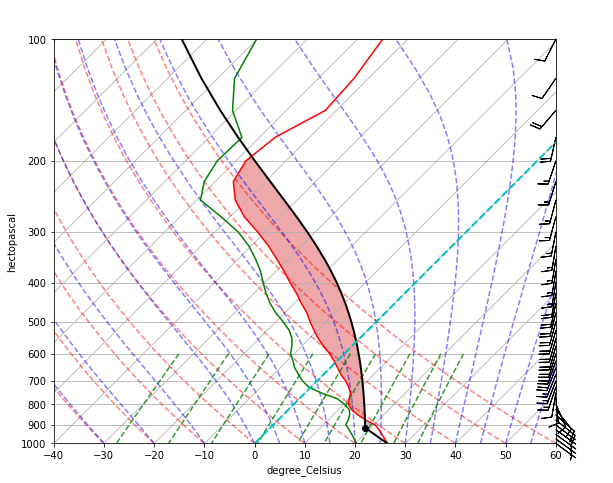

In [25]:
idx = 0
p = np.arange(100, 1025, 25)[::-1] * units.hPa
T = (df[temps].iloc[idx].values[::-1] - 273.15) * units.degC
Td = df[dews].iloc[idx].values[::-1] * units.degC
u = df[us].iloc[idx].values[::-1] * units.knots
v = df[vs].iloc[idx].values[::-1] * units.degrees

fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()


### Derived variables from RAP soundings

surface_based_cape_cin, most_unstable_cape_cin, mixed_layer_cape_cin

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.mixed_layer_cape_cin.html

bulk_shear (0-6km only, not all the way to 16500, get magnitude from vector magnitudes, call "bulk_shear_mag", "bulk_shear_u_6km", etc)

bunkers_storm_motion (u, v, mean)

CRISIS height interpolated soundings

Interpolate Pressure variable at each height
